# Google Api Test

In [39]:
import lib.google_nlp as gnlp
from lib.tokenize_to_sentences import tokenize_to_sentences, trim_new_line
from lib.aylien_nlp import summarize
import matplotlib.pyplot as plt
import pickle
import numpy as np

In [40]:
ANALYSIS_TITLE = """'Innocent' teenager shot dead on towpath was 'in the wrong place at the wrong time'"""

ANALYSIS_TEXT = '''A "wholly innocent" 16-year-old boy was "in the wrong place at the wrong time" when he was shot dead on a canal towpath, a jury has heard.

Lewis Dunne was on his way to a shop when he walked into the path of four men lying in wait with a loaded weapon and with "murderous intent", Liverpool Crown Court was told.

The shooting in Vauxhall, Liverpool, was said to be the culmination of a series of incidents in the area on November 15 last year between two groups of males which involved the deliberate ramming of vehicles, chases and violence on the streets of the city.

Opening the prosecution case, Ian Unsworth QC said: "Put shortly, at the time of the fatal attack upon Lewis Dunne the defendants were intent on revenge.

Lewis Dunne was 'in the wrong place at the wrong time'
"They had obtained a deadly loaded firearm and acting as a group they sought revenge upon those they opposed and who they had had trouble with earlier that day.

"Lewis Dunne was not involved in any of those previous incidents. He was simply on his way to the shop at the time that he lost his life.

"Whether he looked like one of the opposing group or whether they simply believed he was one of the opposing group, they used the gun to shoot him dead as he unwittingly walked into their path."

The prosecutor added: "Lewis Dunne had no axe to grind with these men. He had done nothing wrong."

Three of the men who took part in the "cowardly attack" alongside the Leeds and Liverpool Canal were in the dock, Mr Unsworth said, but police had not yet been able to identify who they say the fourth man was.

Jake Culshaw, 25, of no fixed address, and brothers Paul Martin, 25, and John Martin, 20, both of Ince Avenue, Anfield, deny murder.

The prosecutor told jurors at Liverpol Crown Court: "There is no direct evidence to to say which of those four men pulled the trigger and shot Lewis Dunne.

The simple fact is this - he was shot in the back by one of a group of four males who had walked in darkness along that canal towpath armed with a loaded lethal weapon.

"That we cannot say which person actually shot him does not matter.

"In short, we suggest on a proper analysis of the evidence ... each of the three defendants bears the responsibility for the death of Lewis Dunne."'''

sentences = tokenize_to_sentences(ANALYSIS_TEXT)
print('\n'.join(sentences))

A "wholly innocent" 16-year-old boy was "in the wrong place at the wrong time" when he was shot dead on a canal towpath, a jury has heard.
Lewis Dunne was on his way to a shop when he walked into the path of four men lying in wait with a loaded weapon and with "murderous intent", Liverpool Crown Court was told.
The shooting in Vauxhall, Liverpool, was said to be the culmination of a series of incidents in the area on November 15 last year between two groups of males which involved the deliberate ramming of vehicles, chases and violence on the streets of the city.
Opening the prosecution case, Ian Unsworth QC said: "Put shortly, at the time of the fatal attack upon Lewis Dunne the defendants were intent on revenge.
Lewis Dunne was 'in the wrong place at the wrong time' "They had obtained a deadly loaded firearm and acting as a group they sought revenge upon those they opposed and who they had had trouble with earlier that day.
"Lewis Dunne was not involved in any of those previous incid

In [41]:
# helper functions

def print_sentiment(text, polarity, magnitude):
    print('Text: %s' % text)
    print('Sentiment: polarity of %s with magnitude of %s' % (polarity, magnitude))
    
def load_dump(path):
    return pickle.load(open(path, 'rb'))

#### Analyze and print sentiment for the document:

In [42]:
# Run a sentiment analysis request on text in ANALYSIS_TEXT variable
polarity, magnitude = gnlp.google_sentiment_analysis(ANALYSIS_TEXT)
print('Document Sentiment: polarity of %s with magnitude of %s' % (polarity, magnitude))
print()

Document Sentiment: polarity of -0.9 with magnitude of 8.3



#### Analyze sentiment for each sentence and store a dump:

In [43]:
# analyze using Google API
sentiments = [gnlp.google_sentiment_analysis(sentence) for sentence in sentences]
results = list(zip(sentences, sentiments))

# store to tmp file
pickle.dump(results, open('tmp/google-sentiment-results', 'wb'))

# print success
print('Stored %d results' % len(list(results)))

Stored 16 results


#### Analyze syntax for each sentence and store a dump:

In [44]:
# analyse using Google API
syntax = [gnlp.google_syntax_analysis(sentence) for sentence in sentences]
syntax_results = list(zip(sentences, syntax))

# store to tmp file
pickle.dump(syntax_results, open('tmp/google-syntax-results', 'wb'))

# print success
print('Stored %d results' % len(syntax_results))


Stored 16 results


#### Print sentiment for each sentence:

In [45]:
results = load_dump('tmp/google-sentiment-results')
print('Have found %d results\n\n' % len(list(results)))

for r in results:
    text, (polarity, magnitude) = r
    print_sentiment(text, polarity, magnitude)
    print('\n\n')

Have found 16 results


Text: A "wholly innocent" 16-year-old boy was "in the wrong place at the wrong time" when he was shot dead on a canal towpath, a jury has heard.
Sentiment: polarity of -1 with magnitude of 0.8



Text: Lewis Dunne was on his way to a shop when he walked into the path of four men lying in wait with a loaded weapon and with "murderous intent", Liverpool Crown Court was told.
Sentiment: polarity of -1 with magnitude of 0.8



Text: The shooting in Vauxhall, Liverpool, was said to be the culmination of a series of incidents in the area on November 15 last year between two groups of males which involved the deliberate ramming of vehicles, chases and violence on the streets of the city.
Sentiment: polarity of 1 with magnitude of 0



Text: Opening the prosecution case, Ian Unsworth QC said: "Put shortly, at the time of the fatal attack upon Lewis Dunne the defendants were intent on revenge.
Sentiment: polarity of -1 with magnitude of 0.8



Text: Lewis Dunne was 'in t

#### Build histogram for sentiment distribution:

In [46]:
results = load_dump('tmp/google-sentiment-results')
distribution = [ r[1][0] * r[1][1] for r in results ]

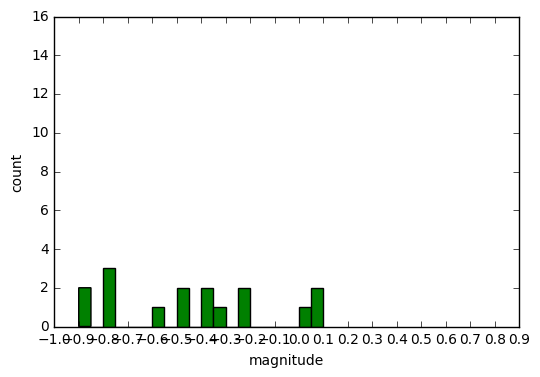

In [47]:
# histogram showing magnitudes
plt.hist(distribution, 20, facecolor='g')
plt.xlabel('magnitude')
plt.xticks(np.arange(-1, 1, 0.1))
plt.ylabel('count')
plt.ylim(0, len(results))
plt.show()

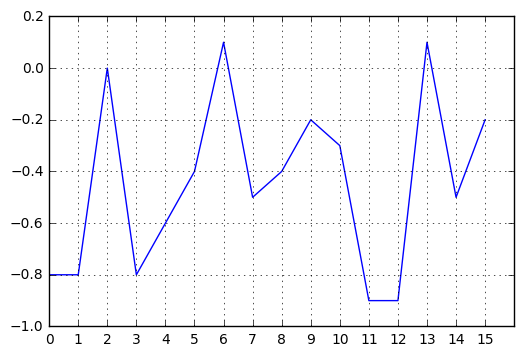

In [48]:
# histogram showing polarity, magnitude in chronological order
plt.plot(distribution)
plt.xticks(np.arange(0, len(distribution), 1.0))
plt.grid()
plt.show()

# Summary Building

First we preprocess our text data by building rankings of sentences by sentiment and finding an adequate summary sentence. Then we apply rules for how we put the article together. See these documents:

- https://docs.google.com/spreadsheets/d/1Q3RqbrvmC2LTuds31R6HSkHc2CpuxZgPJbR5vVsMHlM/edit#gid=0
- https://docs.google.com/document/d/1xWHVi3AaCSE2GduW194sUCYU6peStF4vTctzCZcNYkU/edit

#### Ranking of Sentences

We build a ranking of each sentence by chronological order vs. mag*pol score

In [49]:
sentence_score_tuples = list(zip(range(len(distribution)), distribution))
positives = [t for t in sentence_score_tuples if t[1] >= 0.5]
negatives = [t for t in sentence_score_tuples if t[1] <= -0.5]

# get key to sort by absolute score == magnitude
def getKey(item):
    return item[1]

positives_sorted = sorted(positives, key=getKey)
negatives_sorted = sorted(negatives, key=getKey)

#### Extracting one summary sentence via aylien api

In [50]:
# configure summarization api
options = {
    'mode': 'short',
    'title': ANALYSIS_TITLE,
    'text': trim_new_line(ANALYSIS_TEXT),
    'sentences_number': 1
}

# make api call and cache result
summary_results = summarize(options)
pickle.dump(summary_results, open('tmp/aylien-summary', 'wb'))

In [51]:
summary_results = load_dump('tmp/aylien-summary')
summary_sentences = summary_results['sentences']

#### Filter Summary sentences from ranked positives and negatives

In [52]:
positives_filtered = [p for p in positives_sorted if results[p[0]][0] not in summary_sentences]
negatives_filtered = [p for p in negatives_sorted if results[p[0]][0] not in summary_sentences]

# print filtered & unfiltered counts, so we see where a sentences was deleted
print(negatives_filtered, len(negatives_filtered), len(negatives_sorted))
print(positives_filtered, len(positives_filtered), len(positives_sorted))

[(11, -0.9), (12, -0.9), (0, -0.8), (3, -0.8), (4, -0.6), (7, -0.5), (14, -0.5)] 7 8
[] 0 0


#### Logic for Syntax Splitting

In [53]:
SPLIT_LABELS = [
    'CC',
    'P',
    'MARK'
]

NO_WHITESPACE_LABELS = [
    'P',
    'NEG'
]

def join_tokens(tokens, _from, _to): 
    sentence = ''
#     print()
    for i in range(_from, _to):
        t = tokens[i]
#         print(t['label'], t['text'])
        if t['label'] in NO_WHITESPACE_LABELS:
            sentence = sentence[:-1]
        sentence = sentence + t['text'] + ' '
    return sentence
    
def find_splits(sentence, tokens, max_characters):
    split_index = find_split_index(sentence, tokens, max_characters)
    if split_index == len(tokens):
        return [sentence]
    
    return [join_tokens(tokens, 0, split_index), join_tokens(tokens, split_index, len(tokens))]
    
def find_split_index(sentence, tokens, max_characters=125):
    character_count = len(sentence)
    split_index = len(tokens)
    
    for t in reversed(tokens):
        character_count -= len(t['text'])
     
        if t['label'] in SPLIT_LABELS:
            if character_count <= max_characters:
                return split_index
            
        split_index = split_index - 1
            
    return len(tokens)

# def find_split_position(sentence, tokens, max_characters=125):
#     character_count = len(sentence)
#     force_split_position = max_characters
#     for t in reversed(tokens):
#         character_count -= len(t['text'])
#         if character_count + len(t['text']) > max_characters:
#             force_split_position = character_count
        
#         if t['label'] in SPLIT_LABELS:
#             print(t['label'], character_count)
#             if character_count <= max_characters:
#                 print(t['label'])
#                 return character_count
            
#     return force_split_position

def splitSentence(syntaxes, sentence, index, max_characters=125):
    '''Split a sentence into two parts, when it is longer then max_characters.
    We try to split at meaningful points, e.g. connector words like and'''
    if len(sentence) > max_characters:
        tokens = [{
            'label': t['dependencyEdge']['label'],
            'text': t['text']['content']
            } for t in syntaxes[index][1]['tokens']]
#         split_position = find_position(sentence, tokens, max_characters)
#         return [sentence[:split_position], sentence[split_position:]]
        return find_splits(sentence, tokens, max_characters)
    return [sentence]

In [57]:
syntax_results = load_dump('tmp/google-syntax-results')

def getSentences(score_tuples, sentences):
    '''Returns the original sentences for a score_tuple list'''
    return [(t[0], sentences[t[0]][0]) for t in score_tuples]

def gatherSentences(sentences_list, 
                    max_count=2,
                    max_characters=250,
                    max_split_characters=125,
                    skip_indices=[]):
    '''Builds a list of sentences greedily, so they are not longer 
    than max_characters.'''
    sentences = []
    indices = []
    for (index, s) in sentences_list:
        if index in skip_indices:
            continue
        if len(sentences) >= max_count:
            break
        if len(s) < max_characters:
            splits = splitSentence(syntax_results, s, index, max_split_characters)
            if len(sentences) + len(splits) <= max_count:
                indices.append(index)
                sentences += splits
            
    return (sentences, indices)

(pos, _) = gatherSentences(getSentences(positives_filtered, results))
(neg, neg_indices) = gatherSentences(getSentences(negatives_filtered, results))

summary_syntaxes = list(zip(summary_sentences, [gnlp.google_syntax_analysis(sentence) for sentence in summary_sentences]))
summary = splitSentence(summary_syntaxes, summary_sentences[0], 0, 125)

max_count = 6 - len(pos) - len(neg) - len(summary)
remaining_neg = []
if max_count > 0:
    (remaining_neg, _) = gatherSentences(getSentences(negatives_filtered, results), max_count=max_count, skip_indices=neg_indices)
    



print('neg')
print(neg)
[print(len(s)) for s in neg]
print()
print('sum')
print(summary)
[print(len(s)) for s in summary]
print()
print('rneg')
print(remaining_neg)
[print(len(s)) for s in remaining_neg]
print()
print('pos')
print(pos)
[print(len(s)) for s in pos]

neg
['Jake Culshaw, 25, of no fixed address, and brothers Paul Martin, 25, and John Martin, 20, both of Ince Avenue, Anfield, ', 'deny murder. ']
120
13

sum
['Lewis Dunne was on his way to a shop when he walked into the path of four men lying in wait with a loaded weapon and ', 'with" murderous intent", Liverpool Crown Court was told. ']
117
57

rneg
['The prosecutor told jurors at Liverpol Crown Court:" ', 'There is no direct evidence to to say which of those four men pulled the trigger and shot Lewis Dunne. ']
53
103

pos
[]


[]

# Final Summary

In [55]:
# build summary from analized sentences...
final_summary = neg + summary + remaining_neg + pos
print('\n'.join(final_summary))

Jake Culshaw, 25, of no fixed address, and brothers Paul Martin, 25, and John Martin, 20, both of Ince Avenue, Anfield, 
deny murder. 
Lewis Dunne was on his way to a shop when he walked into the path of four men lying in wait with a loaded weapon and 
with" murderous intent", Liverpool Crown Court was told. 
The prosecutor told jurors at Liverpol Crown Court:" 
There is no direct evidence to to say which of those four men pulled the trigger and shot Lewis Dunne. 
